In [41]:
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import os
import yfinance as yf
from scipy import stats
from scipy.stats import norm, lognorm, t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [42]:
plots_dir: str = "plots"

def plot_unhedged_sensitivity(
    principal_project1, spread_project1,
    principal_project2, spread_project2,
    ebitda, icr_covenant_target, base_bbsy_rate_pct,
    min_bbsy_rate_pct=0.0, max_bbsy_rate_pct=7.0,
    num_plot_points=101, currency_symbol="$",
    plot_file_name="Unhedged_Sensitivity.png" # Default filename
):
    
    bbsy_scenarios_decimal = np.linspace(min_bbsy_rate_pct / 100.0,
                                         max_bbsy_rate_pct / 100.0,
                                         num_plot_points)
    
    annual_interest_project1 = principal_project1 * (bbsy_scenarios_decimal + spread_project1)
    annual_interest_project2 = principal_project2 * (bbsy_scenarios_decimal + spread_project2)
    total_annual_interest_expense = annual_interest_project1 + annual_interest_project2
    
    icr_calculated_values = np.full_like(total_annual_interest_expense, np.nan)
    non_zero_interest_mask = total_annual_interest_expense != 0
    icr_calculated_values[non_zero_interest_mask] = ebitda / total_annual_interest_expense[non_zero_interest_mask]
    
    max_interest_for_covenant = ebitda / icr_covenant_target
    fixed_rate_component_of_interest = (principal_project1 * spread_project1) + \
                                     (principal_project2 * spread_project2)
    total_principal_combined = principal_project1 + principal_project2
    bbsy_at_covenant_breach_decimal = ((max_interest_for_covenant - fixed_rate_component_of_interest) / total_principal_combined) \
                                      if total_principal_combined > 0 else np.nan

    fig, ax_interest = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('white')
    ax_interest.set_facecolor('white')

    color_interest_line = '#1f77b4'
    ax_interest.set_xlabel("Annualized 3-Month BBSY Rate (%)", fontsize=9)
    ax_interest.set_ylabel(f"Total Annual Interest Expense ({currency_symbol}m)", color=color_interest_line, fontsize=9)
    ax_interest.plot(bbsy_scenarios_decimal * 100, total_annual_interest_expense / 1000, color=color_interest_line, linewidth=1.75, label="Annual Interest Expense")
    ax_interest.tick_params(axis='y', labelcolor=color_interest_line, labelsize=8)
    ax_interest.tick_params(axis='x', labelsize=8)
    ax_interest.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_interest.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'{currency_symbol}{y:,.1f}m'))

    ax_icr = ax_interest.twinx()
    color_icr_line = '#ff7f0e'
    ax_icr.set_ylabel("Interest Coverage Ratio (ICR)", color=color_icr_line, fontsize=9)
    ax_icr.plot(bbsy_scenarios_decimal * 100, icr_calculated_values, color=color_icr_line, linewidth=1.75, linestyle='--', label="ICR")
    ax_icr.tick_params(axis='y', labelcolor=color_icr_line, labelsize=8)
    ax_icr.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2fx'))

    ax_icr.axhline(icr_covenant_target, color='#d62728', linestyle=':', linewidth=1.5, label=f"ICR Covenant ({icr_covenant_target:.2f}x)")
    ax_interest.axvline(base_bbsy_rate_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_rate_pct:.2f}%)")
    if not np.isnan(bbsy_at_covenant_breach_decimal):
        ax_interest.axvline(bbsy_at_covenant_breach_decimal * 100, color='red', linestyle=':', linewidth=1.2, alpha=0.8, label=f"ICR Breach BBSY ({bbsy_at_covenant_breach_decimal*100:.2f}%)")

    fig.suptitle("Prime Property Trust: Unhedged Interest Rate Sensitivity", fontsize=12, weight='bold')
    ax_interest.set_title(f"FY25 EBITDA Basis: {currency_symbol}{ebitda/1000:,.1f}m; Total Debt: {currency_symbol}{total_principal_combined/1000:,.0f}m", fontsize=8, pad=8)
    
    lines1, labels1 = ax_interest.get_legend_handles_labels()
    lines2, labels2 = ax_icr.get_legend_handles_labels()
    ax_interest.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=7, frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.15))
    
    ax_interest.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_interest.spines['top'].set_visible(False)
    ax_interest.spines['right'].set_visible(False)
    ax_icr.spines['top'].set_visible(False)

    plt.tight_layout(rect=[0, 0.08, 1, 0.93])
    
    full_file_path = os.path.join(plots_dir, plot_file_name)
    fig.savefig(full_file_path, dpi=1200, bbox_inches='tight')
    print(f"Figure saved to: {full_file_path}")
        
    plt.show()
    return fig

In [43]:
def plot_futures_hedging_outcomes(
    principal_project1, spread_project1,
    principal_project2, spread_project2,
    ebitda_for_icr_calc,
    futures_sale_yield_pct,
    base_bbsy_rate_pct,
    min_bbsy_rate_pct=0.0,
    max_bbsy_rate_pct=7.0,
    num_plot_points=101,
    currency_symbol="$",
    futures_contract_face_value=1000000,
    futures_contract_days=90,
    plot_file_name="Futures_Hedging_Outcomes.png" # Default filename
):
    
    futures_sale_yield_decimal = futures_sale_yield_pct / 100.0
    bbsy_scenarios_decimal = np.linspace(min_bbsy_rate_pct / 100.0, 
                                         max_bbsy_rate_pct / 100.0, 
                                         num_plot_points)
    
    total_principal_combined = principal_project1 + principal_project2
    period_fraction_year = futures_contract_days / 365.0

    # Panel A: P&L per SHORT Futures Contract
    pnl_per_contract = futures_contract_face_value * \
                       (bbsy_scenarios_decimal - futures_sale_yield_decimal) * \
                       period_fraction_year

    # Panel B: Effective Interest Rates
    unhedged_rate_project1 = bbsy_scenarios_decimal + spread_project1
    unhedged_rate_project2 = bbsy_scenarios_decimal + spread_project2
    
    hedged_rate_project1_value = futures_sale_yield_decimal + spread_project1
    hedged_rate_project2_value = futures_sale_yield_decimal + spread_project2
    
    hedged_rate_project1_plot = np.full_like(bbsy_scenarios_decimal, hedged_rate_project1_value)
    hedged_rate_project2_plot = np.full_like(bbsy_scenarios_decimal, hedged_rate_project2_value)
        
    fig, (ax_pnl, ax_rates) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.patch.set_facecolor('white')
    
    ax_pnl.set_facecolor('white')
    ax_pnl.plot(bbsy_scenarios_decimal * 100, pnl_per_contract, color='#2ca02c', linewidth=1.75, label="P&L per Short Futures Contract")
    ax_pnl.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax_pnl.axvline(futures_sale_yield_pct, color='#d62728', linestyle='--', linewidth=1.2, label=f'Futures Lock-in Yield ({futures_sale_yield_pct:.2f}%)')
    ax_pnl.set_ylabel(f"P&L per Contract ({currency_symbol})", fontsize=9)
    ax_pnl.set_title("A: Payoff Profile per Short 90-Day Bank Bill Future", fontsize=10, weight='bold')
    ax_pnl.legend(fontsize=8, loc='upper left', frameon=False)
    ax_pnl.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_pnl.tick_params(axis='y', labelsize=8)
    ax_pnl.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'{currency_symbol}{y:,.0f}'))
    ax_pnl.spines['top'].set_visible(False)
    ax_pnl.spines['right'].set_visible(False)
    ax_pnl.tick_params(axis='x', labelsize=8, direction='out', pad=4)

    ax_rates.set_facecolor('white')
    ax_rates.plot(bbsy_scenarios_decimal * 100, unhedged_rate_project1 * 100, color='cornflowerblue', linestyle=':', linewidth=1.5, label="PCT Unhedged Rate")
    ax_rates.plot(bbsy_scenarios_decimal * 100, hedged_rate_project1_plot * 100, color='blue', linewidth=1.75, label="PCT Hedged Rate")
    ax_rates.plot(bbsy_scenarios_decimal * 100, unhedged_rate_project2 * 100, color='lightcoral', linestyle=':', linewidth=1.5, label="SS Unhedged Rate")
    ax_rates.plot(bbsy_scenarios_decimal * 100, hedged_rate_project2_plot * 100, color='red', linewidth=1.75, label="SS Hedged Rate")
    ax_rates.axvline(base_bbsy_rate_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_rate_pct:.2f}%)")
    ax_rates.set_xlabel("3-Month BBSY at Reset Date (%)", fontsize=9)
    ax_rates.set_ylabel("Effective Annual Interest Rate (%)", fontsize=9)
    ax_rates.set_title("B: Impact on Effective Borrowing Costs by Project", fontsize=10, weight='bold')
    ax_rates.legend(fontsize=8, loc='upper left', frameon=False, ncol=2)
    ax_rates.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_rates.tick_params(axis='both', labelsize=8, direction='out', pad=4)
    ax_rates.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_rates.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_rates.spines['top'].set_visible(False)
    ax_rates.spines['right'].set_visible(False)

    fig.suptitle("Prime Property Trust: Expected Outcomes with Futures Hedging", fontsize=12, weight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    hedged_annual_interest_1 = principal_project1 * hedged_rate_project1_value
    hedged_annual_interest_2 = principal_project2 * hedged_rate_project2_value
    total_hedged_annual_interest = hedged_annual_interest_1 + hedged_annual_interest_2
    
    hedged_icr = np.nan
    if total_hedged_annual_interest != 0:
        hedged_icr = ebitda_for_icr_calc / total_hedged_annual_interest
    
    print(f"\n--- Hedged Scenario Outcomes (Futures Lock-in Yield: {futures_sale_yield_pct:.2f}%) ---")
    print(f"Total Hedged Annual Interest Expense (for {currency_symbol}{total_principal_combined/1000:,.1f}m debt): {currency_symbol}{total_hedged_annual_interest/1000:,.1f}m")
    print(f"Resulting Hedged ICR (with FY25 EBITDA of {currency_symbol}{ebitda_for_icr_calc/1000:,.1f}m): {hedged_icr:.2f}x")
    
    full_file_path = os.path.join(plots_dir, plot_file_name) # Using global plots_dir
    fig.savefig(full_file_path, dpi=1200, bbox_inches='tight')
    print(f"Figure saved to: {full_file_path}")
        
    plt.show()
    return fig


--- Generating Unhedged Sensitivity Plot ---
Figure saved to: plots/Unhedged_Parameter_Sensitivity.png


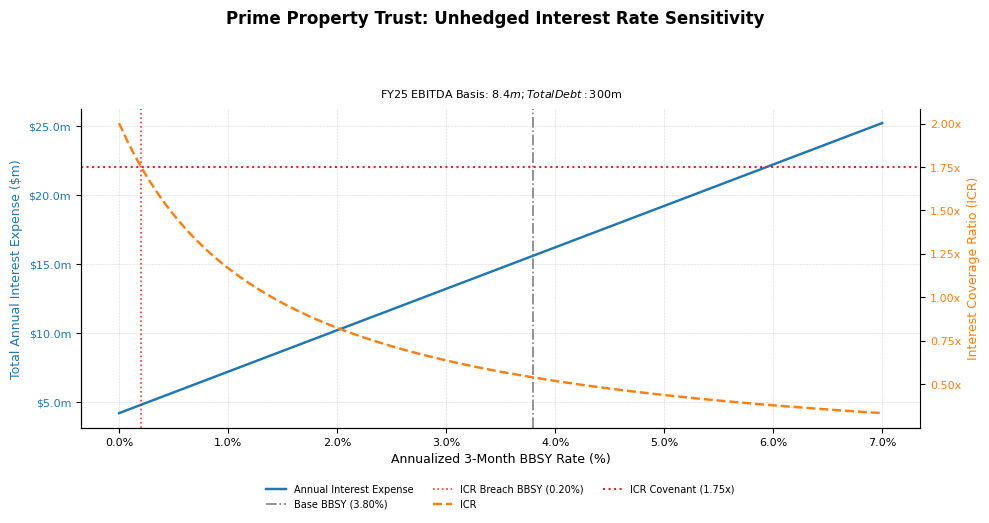


--- Generating Futures Hedging Outcomes Plot ---

--- Hedged Scenario Outcomes (Futures Lock-in Yield: 3.80%) ---
Total Hedged Annual Interest Expense (for $300.0m debt): $15.6m
Resulting Hedged ICR (with FY25 EBITDA of $8.4m): 0.54x
Figure saved to: plots/Futures_Hedging_Outcomes.png


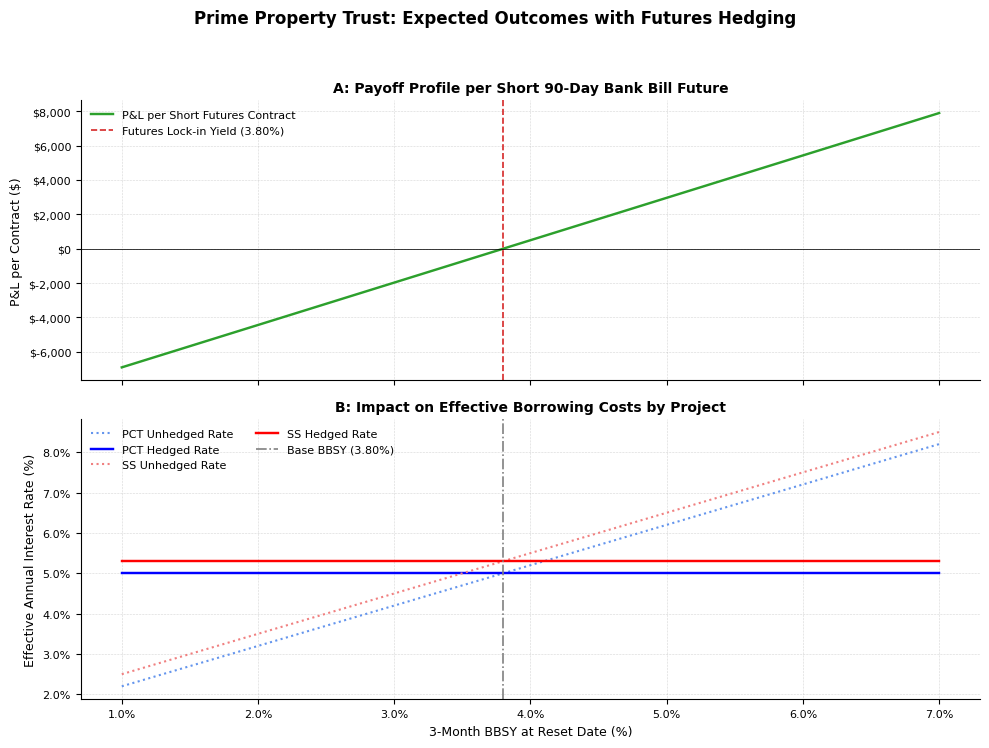

In [44]:
p_pct = 100000 
s_pct = 0.0120    
p_ss = 200000   
s_ss = 0.0150      
ebitda_fy25 = 8412 
bbsy_fy25_base_pct = 3.80 
icr_target = 1.75

# CALIBRATE THIS FROM BLOOMBERG for current market rates for ASX 90-Day Bank Bill Futures
calibrated_futures_sale_yield_pct = 3.80 # Example value

# Call plot_unhedged_sensitivity
print("\n--- Generating Unhedged Sensitivity Plot ---")
fig_unhedged = plot_unhedged_sensitivity(
    principal_project1=p_pct, spread_project1=s_pct,
    principal_project2=p_ss, spread_project2=s_ss,
    ebitda=ebitda_fy25, 
    icr_covenant_target=icr_target,
    base_bbsy_rate_pct=bbsy_fy25_base_pct,
    min_bbsy_rate_pct=0.0,
    max_bbsy_rate_pct=7.0,
    currency_symbol="$",
    plot_file_name="Unhedged_Parameter_Sensitivity.png"
)

# Call plot_futures_hedging_outcomes
print("\n--- Generating Futures Hedging Outcomes Plot ---")
fig_futures = plot_futures_hedging_outcomes(
    principal_project1=p_pct, spread_project1=s_pct,
    principal_project2=p_ss, spread_project2=s_ss,
    ebitda_for_icr_calc=ebitda_fy25, # Pass EBITDA for ICR calc
    futures_sale_yield_pct=calibrated_futures_sale_yield_pct,
    base_bbsy_rate_pct=bbsy_fy25_base_pct,
    min_bbsy_rate_pct=1.0, 
    max_bbsy_rate_pct=7.0,
    currency_symbol="$",
    # contract_face_value and contract_days use defaults
    plot_file_name="Futures_Hedging_Outcomes.png" # Specific name
)

In [45]:
def plot_cap_hedging_outcomes(
    principal_for_panel_b, # Total principal PPT is hedging, for Panel B's effective rate
    spread_for_panel_b,    # Loan spread, for Panel B's effective rate
    cap_strike_rate_pct,
    cap_premium_pct_pa,    # Annualized premium as % of notional
    base_bbsy_pct,
    bbsy_plot_range_min_pct=0.0,
    bbsy_plot_range_max_pct=7.0,
    num_plot_points=101,
    currency_symbol="$",
    interest_period_days=90,
    panel_a_notional_unit=1000000, # Notional for Panel A payoff (e.g., $1m)
    plot_file_name="Cap_Hedging_Outcomes.png" # Default filename
):
    cap_strike_decimal = cap_strike_rate_pct / 100.0
    cap_premium_annual_decimal = cap_premium_pct_pa / 100.0
    bbsy_scenario_decimal_rates = np.linspace(bbsy_plot_range_min_pct / 100.0, 
                                              bbsy_plot_range_max_pct / 100.0, 
                                              num_plot_points)
    
    period_year_fraction = interest_period_days / 365.0

    # Panel A: Payoff & P&L per 'panel_a_notional_unit'
    cap_gross_payoff_panel_a = panel_a_notional_unit * \
                               np.maximum(0, bbsy_scenario_decimal_rates - cap_strike_decimal) * \
                               period_year_fraction
    cap_premium_cost_panel_a = panel_a_notional_unit * \
                               cap_premium_annual_decimal * \
                               period_year_fraction
    cap_net_pnl_panel_a = cap_gross_payoff_panel_a - cap_premium_cost_panel_a

    # Panel B: Effective Interest Rate for 'principal_for_panel_b'
    unhedged_eff_rate_panel_b = bbsy_scenario_decimal_rates + spread_for_panel_b
    capped_bbsy_comp_panel_b = np.minimum(bbsy_scenario_decimal_rates, cap_strike_decimal)
    hedged_eff_rate_panel_b = (capped_bbsy_comp_panel_b + spread_for_panel_b) + \
                              cap_premium_annual_decimal

    fig, (ax_panel_a, ax_panel_b) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.patch.set_facecolor('white')
    
    # Panel A: Caplet P&L
    ax_panel_a.set_facecolor('white')
    ax_panel_a.plot(bbsy_scenario_decimal_rates * 100, cap_gross_payoff_panel_a, color='limegreen', linewidth=1.75, label="Gross Payoff")
    ax_panel_a.plot(bbsy_scenario_decimal_rates * 100, cap_net_pnl_panel_a, color='darkgreen', linewidth=2.0, linestyle='-', label="Net P&L (after premium)")
    ax_panel_a.axhline(-cap_premium_cost_panel_a, color='grey', linestyle=':', linewidth=1, label="Premium Cost")
    ax_panel_a.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax_panel_a.axvline(cap_strike_rate_pct, color='#d62728', linestyle='--', linewidth=1.2, label=f'Cap Strike ({cap_strike_rate_pct:.2f}%)')
    ax_panel_a.set_ylabel(f"Caplet P&L / Cost ({currency_symbol} per period)", fontsize=9)
    ax_panel_a.set_title(f"A: Payoff of Purchased Caplet (per {currency_symbol}{panel_a_notional_unit/1e6:.1f}m Notional)", fontsize=10, weight='bold')
    ax_panel_a.legend(fontsize=8, loc='upper left', frameon=False)
    ax_panel_a.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_panel_a.tick_params(axis='y', labelsize=8)
    ax_panel_a.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y_val, p_val: f'{currency_symbol}{y_val:,.0f}'))
    ax_panel_a.spines['top'].set_visible(False)
    ax_panel_a.spines['right'].set_visible(False)
    ax_panel_a.tick_params(axis='x', labelsize=8, direction='out', pad=4)

    # Panel B: Effective Interest Rates
    ax_panel_b.set_facecolor('white')
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, unhedged_eff_rate_panel_b * 100, color='#1f77b4', linestyle=':', linewidth=1.5, label="Unhedged Rate")
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, hedged_eff_rate_panel_b * 100, color='#ff7f0e', linewidth=1.75, label="Rate with Cap (incl. premium)")
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, (capped_bbsy_comp_panel_b + spread_for_panel_b) * 100, color='orange', linestyle='--', linewidth=1.0, alpha=0.7, label="Capped Rate (excl. premium)")
    ax_panel_b.axvline(base_bbsy_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_pct:.2f}%)")
    ax_panel_b.set_xlabel("3-Month BBSY at Reset Date (%)", fontsize=9)
    ax_panel_b.set_ylabel("Effective Annual Interest Rate (%)", fontsize=9)
    ax_panel_b.set_title(f"B: Impact on PPT's Borrowing Cost (for {currency_symbol}{principal_for_panel_b/1e6:.0f}m Debt)", fontsize=10, weight='bold')
    ax_panel_b.legend(fontsize=8, loc='upper left', frameon=False, ncol=1)
    ax_panel_b.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_panel_b.tick_params(axis='both', labelsize=8, direction='out', pad=4)
    ax_panel_b.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_panel_b.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_panel_b.spines['top'].set_visible(False)
    ax_panel_b.spines['right'].set_visible(False)

    fig.suptitle("Prime Property Trust: Expected Outcomes with Interest Rate Cap Hedging", fontsize=13, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    full_file_path = os.path.join(plots_dir, plot_file_name)
    fig.savefig(full_file_path, dpi=1200, bbox_inches='tight')
    print(f"Figure saved to: {full_file_path}")
        
    plt.show()
    return fig

Figure saved to: plots/Cap_Hedging_Outcomes.png


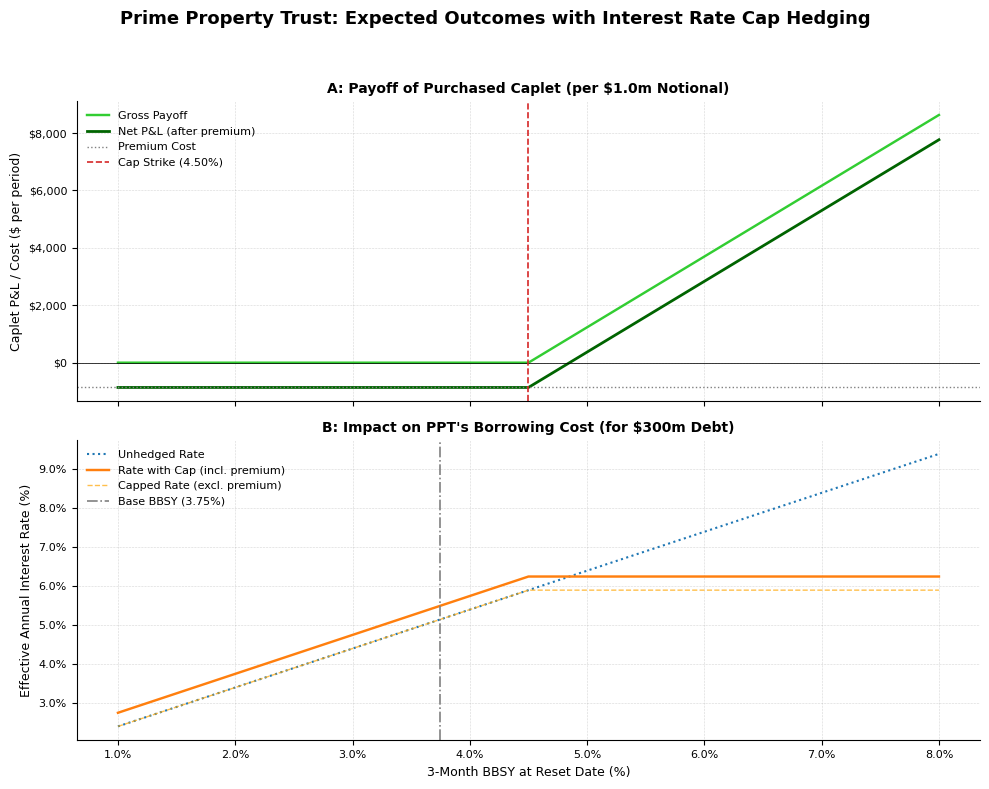

In [46]:
principal_pct_val = 100000000  
spread_pct_val = 0.0120     
principal_ss_val = 200000000   
spread_ss_val = 0.0150      
total_combined_principal_for_ppt = principal_pct_val + principal_ss_val
avg_spread_for_ppt = (principal_pct_val * spread_pct_val + principal_ss_val * spread_ss_val) / total_combined_principal_for_ppt

example_cap_strike_input_pct = 4.50     
example_cap_premium_input_pct_pa = 0.35 

bbsy_fy25_input_pct = 3.75 

# Call the plotting function
fig_cap_outcomes = plot_cap_hedging_outcomes(
    principal_for_panel_b=total_combined_principal_for_ppt,
    spread_for_panel_b=avg_spread_for_ppt,        
    cap_strike_rate_pct=example_cap_strike_input_pct,
    cap_premium_pct_pa=example_cap_premium_input_pct_pa,
    base_bbsy_pct=bbsy_fy25_input_pct,
    bbsy_plot_range_min_pct=1.0, 
    bbsy_plot_range_max_pct=8.0,
    currency_symbol="$",
    interest_period_days=90.0,
    panel_a_notional_unit=1000000,
    plot_file_name="Cap_Hedging_Outcomes.png"
)

In [ ]:
def plot_swap_hedging_outcomes(
    principal_for_panel_b, 
    spread_for_panel_b,    
    fixed_swap_rate_pct,   
    base_bbsy_pct,
    bbsy_plot_range_min_pct=0.0, 
    bbsy_plot_range_max_pct=7.0, 
    num_plot_points=101, 
    currency_symbol="$",
    interest_period_days=90,
    panel_a_notional_unit=1000000, 
    plot_file_name="Swap_Hedging_Outcomes.png" # Default filename
):
    fixed_swap_rate_decimal = fixed_swap_rate_pct / 100.0
    
    # CORRECTED: Use the actual parameter names passed to the function
    bbsy_scenario_decimal_rates = np.linspace(bbsy_plot_range_min_pct / 100.0,
                                              bbsy_plot_range_max_pct / 100.0,
                                              num_plot_points) 
    
    period_year_fraction = interest_period_days / 365.0

    swap_net_settlement_panel_a = panel_a_notional_unit * \
                                  (bbsy_scenario_decimal_rates - fixed_swap_rate_decimal) * \
                                  period_year_fraction

    unhedged_eff_rate_panel_b = bbsy_scenario_decimal_rates + spread_for_panel_b
    hedged_eff_rate_panel_b = np.full_like(bbsy_scenario_decimal_rates, 
                                           fixed_swap_rate_decimal + spread_for_panel_b)

    fig, (ax_panel_a, ax_panel_b) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.patch.set_facecolor('white')
    
    ax_panel_a.set_facecolor('white')
    ax_panel_a.plot(bbsy_scenario_decimal_rates * 100, swap_net_settlement_panel_a, color='#2ca02c', linewidth=1.75, label="Net Swap Settlement (to PPT)")
    ax_panel_a.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax_panel_a.axvline(fixed_swap_rate_pct, color='#d62728', linestyle='--', linewidth=1.2, label=f'Fixed Swap Rate ({fixed_swap_rate_pct:.2f}%)')
    ax_panel_a.set_ylabel(f"Net Swap Settlement ({currency_symbol} per period)", fontsize=9)
    ax_panel_a.set_title(f"A: Net Settlement of Payer Swap (per {currency_symbol}{panel_a_notional_unit/1e6:.1f}m Notional)", fontsize=10, weight='bold')
    ax_panel_a.legend(fontsize=8, loc='upper left', frameon=False)
    ax_panel_a.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_panel_a.tick_params(axis='y', labelsize=8)
    ax_panel_a.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y_val, p_val: f'{currency_symbol}{y_val:,.0f}'))
    ax_panel_a.spines['top'].set_visible(False)
    ax_panel_a.spines['right'].set_visible(False)
    ax_panel_a.tick_params(axis='x', labelsize=8, direction='out', pad=4)

    ax_panel_b.set_facecolor('white')
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, unhedged_eff_rate_panel_b * 100, color='#1f77b4', linestyle=':', linewidth=1.5, label="Unhedged Rate")
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, hedged_eff_rate_panel_b * 100, color='#ff7f0e', linewidth=1.75, label="Effective Rate with Swap")
    ax_panel_b.axvline(base_bbsy_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_pct:.2f}%)")
    ax_panel_b.set_xlabel("3-Month BBSY at Reset Date (%)", fontsize=9)
    ax_panel_b.set_ylabel("Effective Annual Interest Rate (%)", fontsize=9)
    ax_panel_b.set_title(f"B: Impact on PPT's Effective Borrowing Cost (for {currency_symbol}{principal_for_panel_b/1e6:.0f}m Debt)", fontsize=10, weight='bold')
    ax_panel_b.legend(fontsize=8, loc='upper left', frameon=False, ncol=1)
    ax_panel_b.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_panel_b.tick_params(axis='both', labelsize=8, direction='out', pad=4)
    ax_panel_b.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_panel_b.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_panel_b.spines['top'].set_visible(False)
    ax_panel_b.spines['right'].set_visible(False)

    fig.suptitle("Prime Property Trust: Expected Outcomes with Interest Rate Swap Hedging", fontsize=12, weight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    full_file_path = os.path.join(plots_dir, plot_file_name) 
    fig.savefig(full_file_path, dpi=1200, bbox_inches='tight')
    print(f"Figure saved to: {full_file_path}")
        
    plt.show()
    return fig

Figure saved to: plots/Swap_Hedging_Outcomes.png


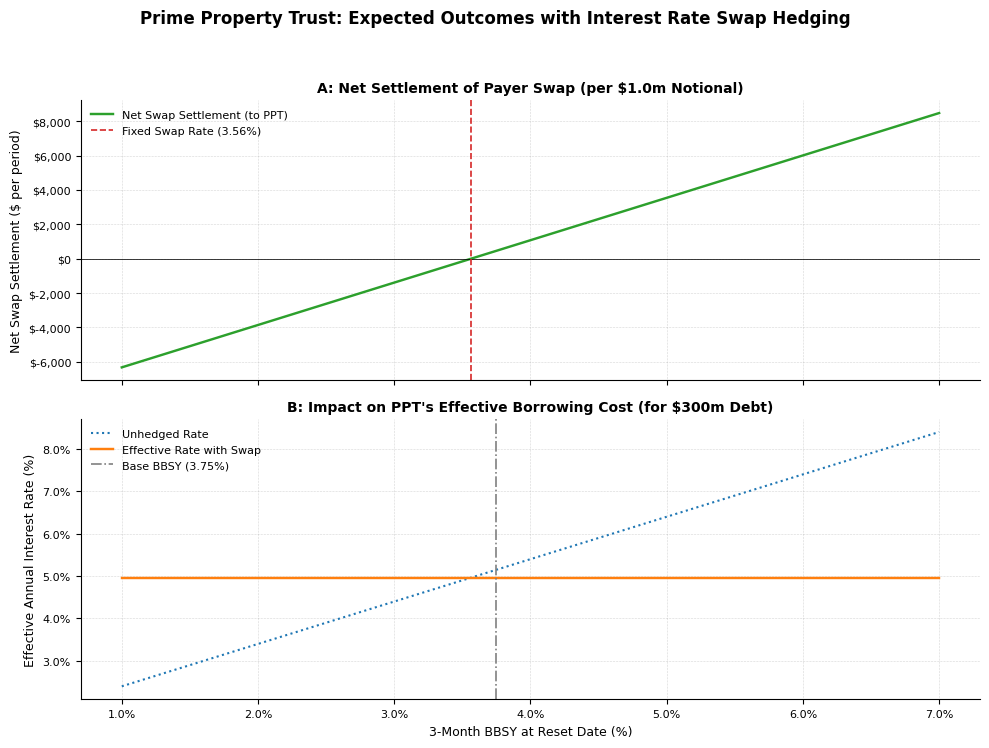

In [48]:
p_pct = 100000000  
s_pct = 0.0120     
p_ss = 200000000   
s_ss = 0.0150      
total_combined_principal_for_ppt = p_pct + p_ss
avg_spread_for_ppt = (p_pct * s_pct + p_ss * s_ss) / total_combined_principal_for_ppt 

bbsy_fy25_input_pct = 3.75

example_fixed_swap_rate_pct = 3.564569

fig_swap_outcomes = plot_swap_hedging_outcomes(
    principal_for_panel_b=total_combined_principal_for_ppt,
    spread_for_panel_b=avg_spread_for_ppt,        
    fixed_swap_rate_pct=example_fixed_swap_rate_pct,
    base_bbsy_pct=bbsy_fy25_input_pct, 
    bbsy_plot_range_min_pct=1.0, 
    bbsy_plot_range_max_pct=7.0,
    num_plot_points=101,
    currency_symbol="$",
    interest_period_days=90.0,
    panel_a_notional_unit=1000000, 
    plot_file_name="Swap_Hedging_Outcomes.png"
)

In [49]:
def plot_fra_hedging_outcomes(
    notional_principal_for_panel_a, # Renamed for clarity, used for Panel A
    principal_for_panel_b,          # Total principal PPT is hedging (for Panel B)
    avg_spread_for_panel_b,         # Weighted average loan spread (for Panel B)
    fra_fixed_rate_pct,             # The agreed fixed rate in the FRA
    base_bbsy_rate_pct,             # For plotting a reference line
    bbsy_plot_range_min_pct=0.0,    # CORRECTED: Parameter name to match call
    bbsy_plot_range_max_pct=7.0,    # CORRECTED: Parameter name to match call
    num_plot_points=101,            # CORRECTED: Parameter name to match call
    currency_symbol="$",
    interest_period_days=90,
    # panel_a_notional_unit renamed to notional_principal_for_panel_a
    plot_file_name="FRA_Hedging_Outcomes.png"
):
    fra_fixed_rate_decimal = fra_fixed_rate_pct / 100.0
    # Use the corrected parameter names from the function signature
    bbsy_scenario_decimal_rates = np.linspace(bbsy_plot_range_min_pct / 100.0,
                                              bbsy_plot_range_max_pct / 100.0,
                                              num_plot_points) 
    
    period_year_fraction = interest_period_days / 365.0

    # Panel A: Net Settlement Payment for an FRA Buyer (PPT)
    numerator_panel_a = notional_principal_for_panel_a * \
                        (bbsy_scenario_decimal_rates - fra_fixed_rate_decimal) * \
                        period_year_fraction
    denominator_panel_a = 1 + (bbsy_scenario_decimal_rates * period_year_fraction)
    fra_net_settlement_panel_a = numerator_panel_a / denominator_panel_a

    # Panel B: Effective Interest Rate for 'principal_for_panel_b'
    unhedged_eff_rate_panel_b = bbsy_scenario_decimal_rates + avg_spread_for_panel_b
    hedged_eff_rate_panel_b = np.full_like(bbsy_scenario_decimal_rates, 
                                           fra_fixed_rate_decimal + avg_spread_for_panel_b)

    fig, (ax_panel_a, ax_panel_b) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.patch.set_facecolor('white')
    
    ax_panel_a.set_facecolor('white')
    ax_panel_a.plot(bbsy_scenario_decimal_rates * 100, fra_net_settlement_panel_a, color='#2ca02c', linewidth=1.75, label="Net FRA Settlement (to PPT)")
    ax_panel_a.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax_panel_a.axvline(fra_fixed_rate_pct, color='#d62728', linestyle='--', linewidth=1.2, label=f'Agreed FRA Rate ({fra_fixed_rate_pct:.2f}%)')
    # Removed base_bbsy_rate_pct from Panel A as it's less relevant here, kept in Panel B
    ax_panel_a.set_ylabel(f"Net FRA Settlement ({currency_symbol} per period)", fontsize=9)
    ax_panel_a.set_title(f"A: Net Settlement for FRA Buyer (per {currency_symbol}{notional_principal_for_panel_a/1e6:.1f}m Notional)", fontsize=10, weight='bold')
    ax_panel_a.legend(fontsize=8, loc='upper left', frameon=False)
    ax_panel_a.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_panel_a.tick_params(axis='y', labelsize=8)
    ax_panel_a.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y_val, p_val: f'{currency_symbol}{y_val:,.0f}'))
    ax_panel_a.spines['top'].set_visible(False)
    ax_panel_a.spines['right'].set_visible(False)
    ax_panel_a.tick_params(axis='x', labelsize=8, direction='out', pad=4)

    ax_panel_b.set_facecolor('white')
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, unhedged_eff_rate_panel_b * 100, color='#1f77b4', linestyle=':', linewidth=1.5, label="Unhedged Rate")
    ax_panel_b.plot(bbsy_scenario_decimal_rates * 100, hedged_eff_rate_panel_b * 100, color='#ff7f0e', linewidth=1.75, label="Effective Rate with FRA")
    ax_panel_b.axvline(base_bbsy_rate_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_rate_pct:.2f}%)")
    ax_panel_b.set_xlabel("3-Month BBSY at Settlement Date (%)", fontsize=9)
    ax_panel_b.set_ylabel("Effective Annual Interest Rate (%)", fontsize=9)
    ax_panel_b.set_title(f"B: Impact on PPT's Effective Borrowing Cost (for {currency_symbol}{principal_for_panel_b/1e6:.0f}m Debt)", fontsize=10, weight='bold')
    ax_panel_b.legend(fontsize=8, loc='upper left', frameon=False, ncol=1)
    ax_panel_b.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_panel_b.tick_params(axis='both', labelsize=8, direction='out', pad=4)
    ax_panel_b.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_panel_b.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_panel_b.spines['top'].set_visible(False)
    ax_panel_b.spines['right'].set_visible(False)

    fig.suptitle("Prime Property Trust: Expected Outcomes with FRA Hedging", fontsize=12, weight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    full_file_path = os.path.join(plots_dir, plot_file_name) 
    fig.savefig(full_file_path, dpi=1200, bbox_inches='tight')
    print(f"Figure saved to: {full_file_path}")
        
    plt.show()
    return fig

Figure saved to: plots/FRA_Hedging_Outcomes.png


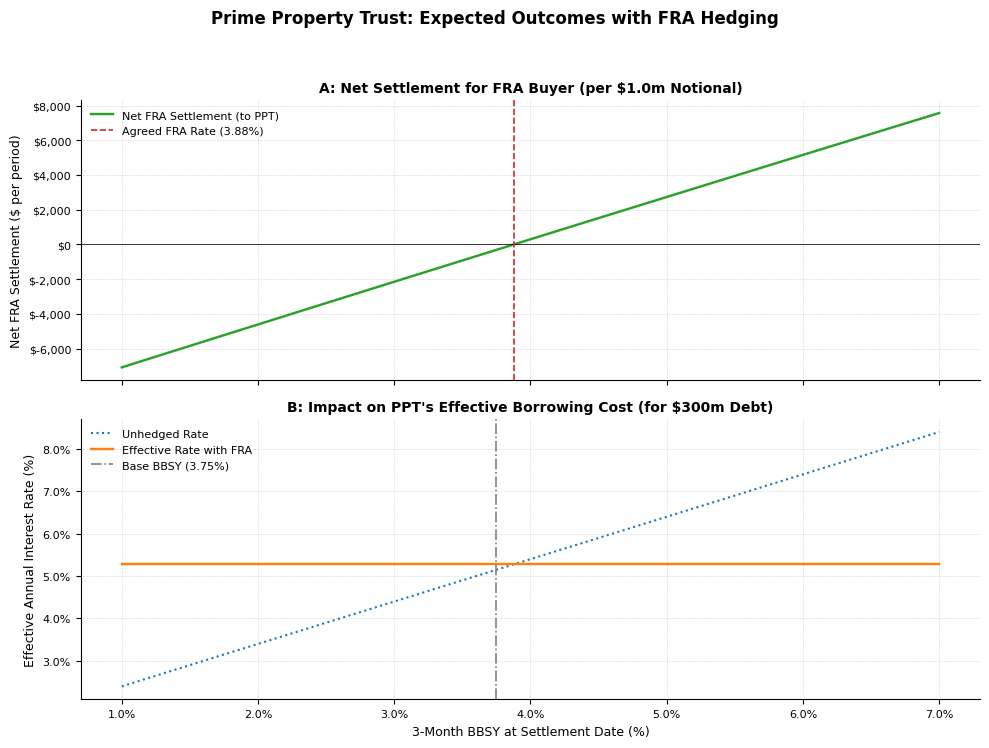

In [50]:
principal_pct_val = 100000000
spread_pct_val = 0.0120
principal_ss_val = 200000000
spread_ss_val = 0.0150
total_combined_principal_for_ppt = principal_pct_val + principal_ss_val
avg_spread_for_ppt = (principal_pct_val * spread_pct_val + principal_ss_val * spread_ss_val) / total_combined_principal_for_ppt

bbsy_fy25_input_pct = 3.75

example_fra_agreed_rate_pct = 3.87886 

# Call the plotting function
fig_fra_outcomes = plot_fra_hedging_outcomes(
    notional_principal_for_panel_a=1000000, # Panel A P&L calculated for $1m notional
    principal_for_panel_b=total_combined_principal_for_ppt,
    avg_spread_for_panel_b=avg_spread_for_ppt,
    fra_fixed_rate_pct=example_fra_agreed_rate_pct,
    base_bbsy_rate_pct=bbsy_fy25_input_pct,
    bbsy_plot_range_min_pct=1.0,
    bbsy_plot_range_max_pct=7.0,
    num_plot_points=101,
    currency_symbol="$",
    interest_period_days=90.0,
    plot_file_name="FRA_Hedging_Outcomes.png"
)